In [1]:
!pip install duckdb

In [2]:
%matplotlib inline

# adding project dirs to path so code may be referenced from the notebook
import sys
sys.path.insert(0, '..')

In [3]:
import duckdb
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import config
import utils

# Query some forcast data from parquet files
import importlib
import queries
importlib.reload(queries)

<module 'queries' from '/home/matt/repos/hydro-evaluation/src/evaluation/queries/queries.py'>

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.58 µs


<AxesSubplot: >

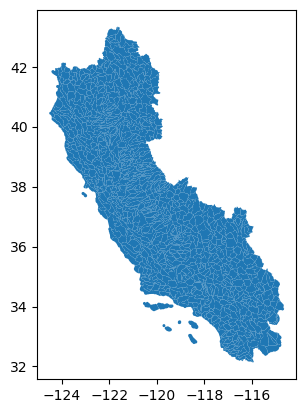

In [4]:
# load huc10
%time
basins_gdf = utils.parquet_to_gdf(config.HUC10_PARQUET_FILEPATH)

# Filter to CA
ca_gdf = basins_gdf.loc[basins_gdf["huc10"].str.startswith("18")]
ca_gdf.plot()

In [5]:
# load usgs gages
%time
usgs_gages = utils.get_usgs_gages()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


In [6]:
ca_usgs_gages = gpd.sjoin(usgs_gages, ca_gdf,how='inner', predicate='within')

<AxesSubplot: >

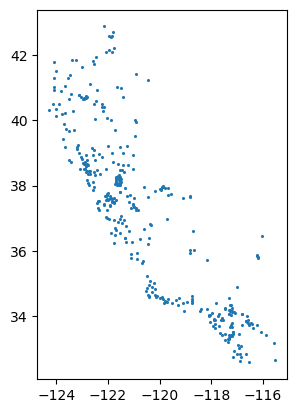

In [7]:
ca_usgs_gages.plot(markersize=1.5)

In [8]:
ca_nwm_fids = list(ca_usgs_gages["nwm_feature_id"])

In [9]:
query = queries.calculate_nwm_feature_metrics(
    config.MEDIUM_RANGE_PARQUET,
    config.USGS_PARQUET,
    group_by=["nwm_feature_id"],
    order_by=["observed_average"],
    filters=[
        {
            "column": "reference_time",
            "operator": "=",
            "value": "2023-01-03 12:00:00"
        }
    ]
)
print(query)
df = duckdb.query(query).to_df()
df

{'column': 'reference_time', 'operator': '=', 'value': '2023-01-03 12:00:00'}

        WITH joined as (
            SELECT 
                nd.reference_time,
                nd.value_time,
                nd.nwm_feature_id,   
                nd.value as forecast_value, 
                nd.configuration,  
                nd.measurement_unit,     
                nd.variable_name,
                ud.value as observed_value,
                ud.usgs_site_code,
                nd.value_time - nd.reference_time as lead_time
            FROM '/home/matt/cache/parquet/medium_range/*.parquet' nd 
            JOIN '/home/matt/cache/nwm/route_link_conus.parquet' nux 
                on nux.nwm_feature_id = nd.nwm_feature_id 
            JOIN '/home/matt/cache/parquet/usgs/*.parquet' ud 
                on nux.gage_id = ud.usgs_site_code 
                and nd.value_time = ud.value_time 
                and nd.measurement_unit = ud.measurement_unit
                and nd.variable_name = ud.var

,nwm_feature_id,intercept,covariance,corr,r_squared,forecast_count,observed_count,forecast_average,observed_average,forecast_variance,observed_variance,max_forecast_delta,bias
0,3109,NaN,0.000000e+00,NaN,NaN,240,240,88.002677,-999999.000000,5.628236e+02,0.000000e+00,1.000141e+06,-1.000087e+06
1,188199,NaN,0.000000e+00,NaN,NaN,240,240,7.090890,-999999.000000,9.091478e-03,0.000000e+00,1.000006e+06,-1.000006e+06
2,190871,NaN,0.000000e+00,NaN,NaN,240,240,463.003246,-999999.000000,1.141885e+00,0.000000e+00,1.000467e+06,-1.000462e+06
3,231167,NaN,0.000000e+00,NaN,NaN,240,240,0.076515,-999999.000000,4.818755e-02,0.000000e+00,1.000000e+06,-9.999991e+05
4,239166,NaN,0.000000e+00,NaN,NaN,237,237,65.154812,-999999.000000,3.984745e-01,0.000000e+00,1.000065e+06,-1.000064e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6963,11866736,130081.971391,5.735323e+08,0.204692,0.041899,240,240,152886.510124,308612.500000,1.011498e+09,7.761579e+09,-2.124192e+05,1.557260e+05
6964,1841415,200876.657729,4.361339e+08,0.115612,0.013366,238,238,218496.458049,412764.705882,1.392888e+09,1.021695e+10,-2.543620e+05,1.942682e+05
6965,19088319,521654.660979,-6.117597e+08,-0.627754,0.394075,110,110,416407.303977,432390.909091,3.778652e+08,2.513311e+09,-6.537425e+04,1.598361e+04
6966,7474830,173181.788018,4.420921e+09,0.887339,0.787370,240,240,279935.312240,502025.000000,1.193963e+09,2.079007e+10,-3.106832e+05,2.220897e+05


<AxesSubplot: >

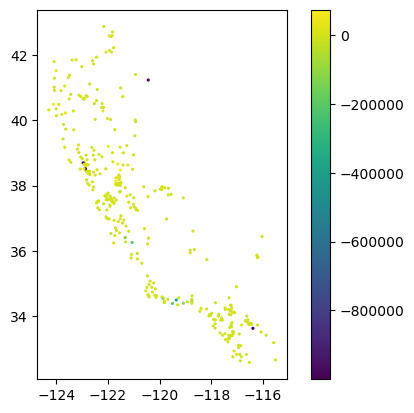

In [11]:
# Join query to basins
gdf_map = ca_usgs_gages.merge(df, left_on="nwm_feature_id", right_on="nwm_feature_id")

gdf_map.plot("observed_average", legend=True, markersize=1.5)